In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import fidap
from config import api_key
import tobler
from shapely import wkt

# instantiate api connection
fidap = fidap.fidap_client(api_key=api_key)

### Interpolation  
  
Interpolation is a technique that recalculates the distribution of data using a scale that is different from that at the original point of data collection. An example could be interpolating rates of COVID-19 vaccination from the scale of zip codes to census tracts. The NYC Covid Vaccination data can be obtained from Github fairly readily.   

In [66]:
# nyc covid19 vax df on github provided by nyc
nyc_covid_vaccination_url = "https://raw.githubusercontent.com/nychealth/covid-vaccine-data/main/people/coverage-by-modzcta-allages.csv"
nyc_vax_df = pd.read_csv(nyc_covid_vaccination_url)

nyc_vax_df.head(n=5)

## nyc vax df for 2 shots 
nyc_2vax = nyc_vax_df.copy().loc[:,['MODZCTA', 'PERC_FULLY', 'POP_DENOMINATOR']]

In [5]:
# getting nyc zip codes boundaries
nyc_boundaries = fidap.sql("""
SELECT * 
FROM bigquery-public-data.geo_us_boundaries.zip_codes
WHERE state_fips_code = '36'
AND city LIKE 'New York%';
""")

In [26]:
# inner join based on zip codes
nyc_boundaries_2vax = nyc_boundaries.merge(nyc_2vax, 'inner', 
                                           left_on = 'zip_code', right_on = 'MODZCTA')

# converting to geodataframe
nyc_boundaries_2vax['zip_code_geom'] = nyc_boundaries_2vax['zip_code_geom'].apply(wkt.loads)
nyc_boundaries_2vax = gpd.GeoDataFrame(nyc_boundaries_2vax, geometry = 'zip_code_geom', crs = 'epsg:3857')
nyc_boundaries_2vax = nyc_boundaries_2vax.rename(columns = {'zip_code_geom': 'geometry'})

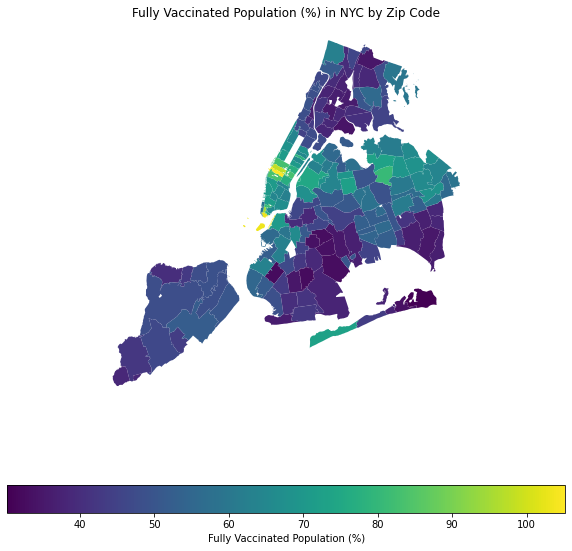

In [17]:
# plotting
f, ax = plt.subplots(figsize = (10,10))
nyc_boundaries_2vax.plot(ax = ax, column = 'PERC_FULLY', legend = True, 
                        legend_kwds = {
                            'label': 'Fully Vaccinated Population (%)',
                            'orientation': 'horizontal'
                        })
ax.set_axis_off()
ax.set_title("Fully Vaccinated Population (%) in NYC by Zip Code")
plt.show()

In [59]:
# getting nyc census tracts boundaries
## includes water areas which is inconvenient
### nyc_census_boundaries = fidap.sql("""
### SELECT tract_geom, geo_id, county_fips_code 
### FROM bigquery-public-data.geo_census_tracts.census_tracts_new_york
### WHERE county_fips_code IN ('005', '061', '081', '085', '047');
### """)


# converting to geodataframe and ensuring similar crs
nyc_census_boundaries = pd.read_csv('./nyc_census_tracts_wo_water/nyct2010.csv')
nyc_census_boundaries['the_geom'] = nyc_census_boundaries['the_geom'].apply(wkt.loads)
nyc_census_boundaries = gpd.GeoDataFrame(nyc_census_boundaries, geometry='the_geom', crs = 'epsg:3857')
nyc_census_boundaries = nyc_census_boundaries.rename(columns = {'the_geom':'geometry'})

In [67]:
# interpolate 
nyc_2vax_interpolate = tobler.area_weighted.area_interpolate(source_df = nyc_boundaries_2vax,
                                                            target_df = nyc_census_boundaries,
                                                            intensive_variables = ['PERC_FULLY'])

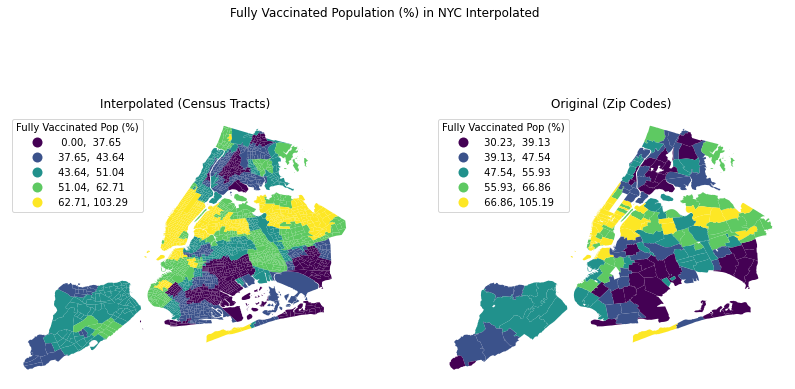

In [86]:
# plotting
f2, ax2 = plt.subplots(1,2, figsize = (14,7))
nyc_2vax_interpolate.plot(ax = ax2[0], column = 'PERC_FULLY', scheme = 'quantiles', 
                          legend = True, legend_kwds = {
                              'loc': 2,
                              'title': 'Fully Vaccinated Pop (%)'
                          }
                          )
nyc_boundaries_2vax.plot(ax = ax2[1], column = 'PERC_FULLY', scheme = 'quantiles', 
                         legend = True, legend_kwds = {
                              'loc': 2,
                              'title': 'Fully Vaccinated Pop (%)'
                          })
ax2[0].set_title("Interpolated (Census Tracts)")
ax2[1].set_title("Original (Zip Codes)")
for ax in ax2:
    ax.set_axis_off()
f2.suptitle("Fully Vaccinated Population (%) in NYC Interpolated")
plt.show()